In [48]:
import numpy as np
from integrator import evolve
from matplotlib import pyplot as plt
from scipy.integrate import odeint
from physics.dynamics import acceleration
from physics.orbits import compute_L2, orbital_period, optimal_L2_orbit, pos_earth_moon
from physics.constants import m_earth_SI, m_moon_SI, d_earth_moon_SI, G_SI

In [ ]:
T = orbital_period()
time_step = 1
max_time = 1*T 
time = np.arange(0, max_time, time_step)
print(np.shape(time))
print(f"Simulating for {max_time:.2f}  with time step {time_step:.7f} seconds.")
print(f"Number of steps: {len(time)}")

(2286568,)
Simulating for 2286567.39  with time step 1.0000000 seconds.
Number of steps: 2286568


In [50]:
ratio = 1.048615084215125
pos_L2, v_L2 = compute_L2(alpha = ratio)
r_L2 = optimal_L2_orbit(pos_L2, time)
print(np.shape(r_L2))

(2286568, 3)


In [51]:
r_earth_barycenter, r_moon_barycenter = pos_earth_moon(time)

In [52]:
def acceleration(r_rocket_barycenter, t):
    r_rocket_barycenter = np.array(r_rocket_barycenter, dtype=float)
    pos_earth, pos_moon = pos_earth_moon(t)

    # Handle both single and multiple vectors
    if r_rocket_barycenter.ndim == 1:
        # Single vector case
        r_rocket_earth = r_rocket_barycenter - pos_earth
        r_rocket_moon  = r_rocket_barycenter - pos_moon

        dist_earth = np.linalg.norm(r_rocket_earth)
        dist_moon  = np.linalg.norm(r_rocket_moon)

        a_rocket_earth = -G_SI * m_earth_SI * r_rocket_earth / dist_earth**3
        a_rocket_moon  = -G_SI * m_moon_SI  * r_rocket_moon  / dist_moon**3

    else:
        # Multiple vectors (N,3)
        r_rocket_earth = r_rocket_barycenter - pos_earth
        r_rocket_moon  = r_rocket_barycenter - pos_moon

        dist_earth = np.linalg.norm(r_rocket_earth, axis=1)
        dist_moon  = np.linalg.norm(r_rocket_moon,  axis=1)

        a_rocket_earth = -G_SI * m_earth_SI * r_rocket_earth / dist_earth[:, None]**3
        a_rocket_moon  = -G_SI * m_moon_SI  * r_rocket_moon  / dist_moon[:, None]**3

    return a_rocket_earth + a_rocket_moon

In [53]:
def model(t, Y):
    y = Y[:3]  
    dy = Y[3:]       # unpack
    dYdt = np.concatenate((dy, acceleration(y,t)))
    return dYdt

In [ ]:
from scipy.integrate import solve_ivp
t_span = (0, T)
t_eval = np.linspace(*t_span, 5000)
Y0 = np.concatenate((pos_L2,v_L2))
sol = solve_ivp(
    model, 
    t_span, 
    Y0, 
    method="RK45",
    rtol=1e-10, atol=1e-12,  # tighten tolerances
    t_eval=t_eval
)

x1, y1, z1 = sol.y[0], sol.y[1], sol.y[2]

In [55]:
# integrate
Y0 = np.concatenate((pos_L2,v_L2))
sol = odeint(model, Y0, time)

# extract y(t)
x, y, z = sol[:,0], sol[:,1], sol[:,2]
print(np.shape(y))

TypeError: 'float' object is not subscriptable

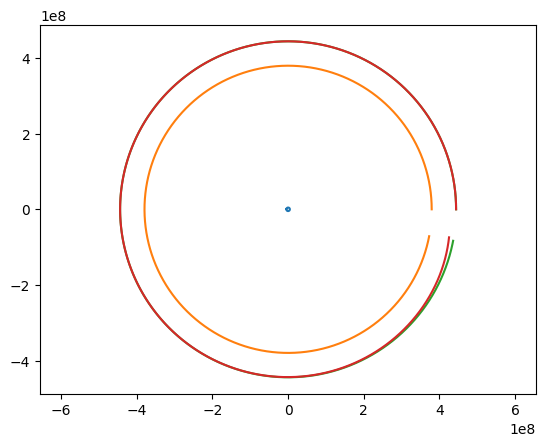

In [58]:
plt.plot(r_earth_barycenter[:,0], r_earth_barycenter[:,1], label='Earth Orbit')
plt.plot(r_moon_barycenter[:,0], r_moon_barycenter[:,1], label='Moon Orbit')
plt.plot(r_L2[:,0], r_L2[:,1], label='L2 Orbit')
plt.plot(x1,y1,label='Solved Orbit')
plt.axis('equal')
plt.show()